#Clustering Analysis - Breakfast Cereals

With a set of nutritional data, consisting of 14 features for 77 different cereals, we can explore unsupervised machine learning techniques known as clustering. Once our data has been prepared properly, we can use different methods to group the cereals together and look for meaningful patterns in the clusters.

First, we import the required packages:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy
from sklearn.preprocessing import Imputer

%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

##Data import and cleaning

Then read in the data, replacing missing values with None (first pass):

In [2]:
data = pd.read_csv('cereals.csv')  # next time set na_values=-1... to simplify this
print('Missing (-1) values:\n', data[data==-1].dropna(how='all',axis=[0,1]))
columns = data[data==-1].dropna(how='all',axis=[0,1]).columns
for col in columns:
    data.loc[data[col]==-1, col] = None# int(data[col].mean())
    # Use None here instaed of the mean, especially since the -1 will affect mean()
data = pd.get_dummies(data, columns=['mfr','type'])  # Convert mfr and type to numbers
data.head()

Missing (-1) values:
     carbo  sugars  potass
4     NaN     NaN      -1
20    NaN     NaN      -1
57     -1      -1     NaN


,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
0,100%_Bran,70,4,1,130,10,5,6,280,25,...,0.33,0,0,0,1,0,0,0,1,0
1,100%_Natural_Bran,120,3,5,15,2,8,8,135,0,...,1.00,0,0,0,0,0,1,0,1,0
2,All-Bran,70,4,1,260,9,7,5,320,25,...,0.33,0,0,1,0,0,0,0,1,0
3,All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330,25,...,0.50,0,0,1,0,0,0,0,1,0
4,Almond_Delight,110,2,2,200,1,14,8,NaN,25,...,0.75,0,0,0,0,0,0,1,1,0


In [3]:
data[data==-1].dropna(how='all',axis=[0,1])  # Verify the -1s are removed

""


Now we'll look for correlations between features (columns), filtering out anything with a low score (not correlated)

In [4]:
corrs = data.corr()
for i in range(len(corrs)):
    # Replace all the diagonals with None, so they can be dropped
    corrs.ix[i,i] = None
sig = corrs[(corrs>0.5) | (corrs < -0.5)].dropna(how='all', axis=[0,1]) # Drop insignificant row/col
sig

,calories,protein,fiber,sugars,potass,weight,cups,mfr_A,type_C,type_H
calories,NaN,NaN,NaN,0.566533,NaN,0.696091,NaN,NaN,NaN,NaN
protein,NaN,NaN,0.500330,NaN,0.563706,NaN,NaN,NaN,NaN,NaN
fiber,NaN,0.500330,NaN,NaN,0.911528,NaN,-0.513061,NaN,NaN,NaN
sugars,0.566533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
potass,NaN,0.563706,0.911528,NaN,NaN,NaN,-0.501607,NaN,NaN,NaN
weight,0.696091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cups,NaN,NaN,-0.513061,NaN,-0.501607,NaN,NaN,NaN,NaN,NaN
mfr_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.569703,0.569703
type_C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.569703,NaN,-1.000000
type_H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569703,-1.000000,NaN


We can also plot a (very dense) diagram plotting each feature against another to visually see correlations or lack thereof.

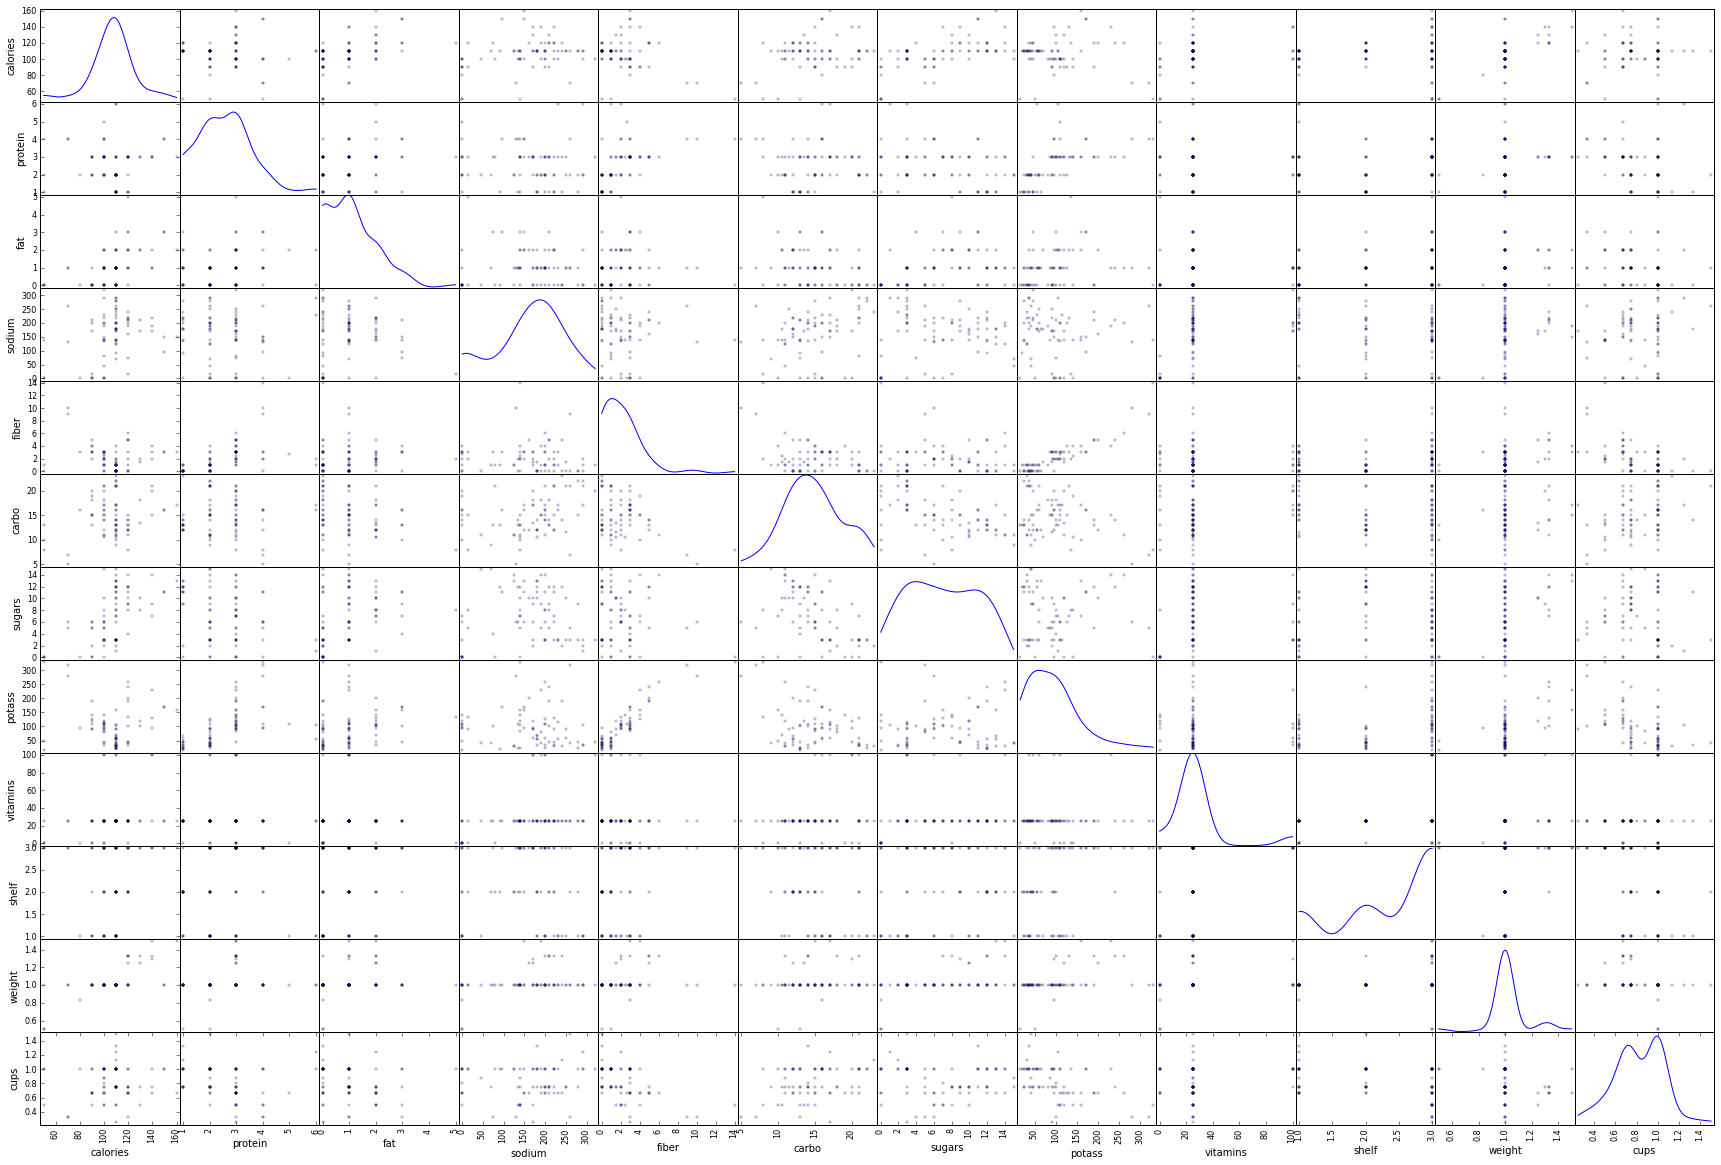

In [5]:
scatter_matrix(data.ix[:,:-9], alpha=0.2, figsize=(30, 20), diagonal='kde');

###Observations:
- Both sugar and weight have a positive correlation with total calories, which is not too surprising
- Protein is mildly correlated with both fiber and potassium content
- Fiber is also strongly positively correlated with potassium content
- On the other hand, fiber is negatively correlated with the volume (cups) of a cereal (a little goes a long way)
- For the categorical data, we learn that cold cereals are never hot in this data set, and that manufacturer "A" favors hot cereals
- We can make an educated guess to replace the two missing potassium values (using linear regression), but there are no strong correlations to help us with the sugar or carb content

###We can replace 2 of the 4 missing values with linear regression

In [6]:
data.iloc[[4,20,57]].ix[:,:-9]

,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
4,Almond_Delight,110,2,2,200,1.0,14,8,NaN,25,3,1,0.75
20,Cream_of_Wheat_(Quick),100,3,0,80,1.0,21,0,NaN,0,2,1,1.00
57,Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110,0,1,1,0.67


In [7]:
#Now do linear regression on fiber

from sklearn.linear_model import LinearRegression
from sklearn.cluster import MeanShift, estimate_bandwidth
not_missing = data.dropna(how='any')
lr = LinearRegression()
y = not_missing['potass']
x = not_missing['fiber'].to_frame()
lr.fit(x,y)
lr.predict(1) # both missing potassium values have fiber content of 1.0


array([ 67.1707])

In [8]:
#data.ix['potass', 4] = lr.predict(1)   # incorrect syntax
data.loc[4, 'potass'] = lr.predict(1) # one way to do it
data.set_value(20, 'potass', lr.predict(1)) # more performant way
data.iloc[[4,20,57]].ix[:,:-9]


,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
4,Almond_Delight,110,2,2,200,1.0,14,8,67.170686,25,3,1,0.75
20,Cream_of_Wheat_(Quick),100,3,0,80,1.0,21,0,67.170686,0,2,1,1.00
57,Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110.000000,0,1,1,0.67


###Now we can use the Imputer to fill in the other two with the mean across the dataset

In [9]:
data = data.set_index('name') # Get all strings out of columns, so that we can impute the mean
data.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,
100%_Bran,70,4,1,130,10,5,6,280.000000,25,3,...,0.33,0,0,0,1,0,0,0,1,0
100%_Natural_Bran,120,3,5,15,2,8,8,135.000000,0,3,...,1.00,0,0,0,0,0,1,0,1,0
All-Bran,70,4,1,260,9,7,5,320.000000,25,3,...,0.33,0,0,1,0,0,0,0,1,0
All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330.000000,25,3,...,0.50,0,0,1,0,0,0,0,1,0
Almond_Delight,110,2,2,200,1,14,8,67.170686,25,3,...,0.75,0,0,0,0,0,0,1,1,0


In [10]:
data.iloc[[4,20,57]].ix[:,:-9]

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
name,,,,,,,,,,,,
Almond_Delight,110,2,2,200,1.0,14,8,67.170686,25,3,1,0.75
Cream_of_Wheat_(Quick),100,3,0,80,1.0,21,0,67.170686,0,2,1,1.00
Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110.000000,0,1,1,0.67


In [41]:
imp = Imputer(missing_values='NaN', strategy='mean')#, axis=0)#, verbose=0, copy=True)
df = pd.DataFrame(imp.fit_transform(data), columns=data.columns, index=data.index)
df.iloc[56:59]  #Note Quaker_Oatmeal sugar and carbo NaN's have been filled in

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,
Quaker_Oat_Squares,100,4,1,135,2.0,14.000000,6.000000,110,25,3,...,0.50,0,0,0,0,0,1,0,1,0
Quaker_Oatmeal,100,5,2,0,2.7,14.802632,7.026316,110,0,1,...,0.67,0,0,0,0,0,1,0,0,1
Raisin_Bran,120,3,1,210,5.0,14.000000,12.000000,240,25,2,...,0.75,0,0,1,0,0,0,0,1,0


In [19]:
## May need to normalize to something (maybe calories), 
## but test as is (appears to be normalized to 1 serving)

##Now we are ready to perform clustering tasks

In [20]:
kmeans = KMeans(5)
scaled = preprocessing.scale(df)
kmeans.fit(scaled)
clusters = (kmeans.predict(scaled))
print(kmeans.cluster_centers_)
print(clusters)
#centroids, clusters = kmeans(img_data, 3)

[[-0.0198  0.0961 -0.363   0.8444 -0.3387  1.0496 -0.7697 -0.4406  0.6984
  -0.1908 -0.0977  0.6054 -0.1147  0.0316  0.2213 -0.2907 -0.3638 -0.3405
   0.6427  0.2013 -0.2013]
 [ 0.118  -0.8463 -0.0963 -0.0361 -0.5745 -0.5431  0.881  -0.6342 -0.1463
  -0.5031 -0.1981  0.1757 -0.1147  0.3821  0.0757 -0.2907  0.0253 -0.0674
  -0.3405  0.2013 -0.2013]
 [ 0.3547  0.6861  0.6537  0.0039  0.8861 -0.4567  0.2253  1.0606 -0.0524
   0.8571  0.6799 -0.7921 -0.1147 -0.1713 -0.0154 -0.1353  0.4143  0.0692
  -0.0674  0.2013 -0.2013]
 [-0.3556  1.3373 -0.013  -1.9172 -0.9088  0.3105 -0.9317 -0.0412 -0.1463
  -0.2512 -0.1981  0.7741  8.7178 -0.6325 -0.6526 -0.2907 -0.3638 -0.3405
  -0.3405 -4.9666  4.9666]
 [-1.3242  0.0731 -0.7631 -1.7746  0.0256  0.3365 -1.2781 -0.1727 -1.1318
  -0.5535 -1.1764  0.2388 -0.1147 -0.6325 -0.6526  2.041  -0.3638  0.8885
  -0.3405 -1.0906  1.0906]]
[2 2 2 2 0 1 1 2 0 2 1 0 1 2 1 0 0 1 1 2 4 0 1 0 1 1 1 2 2 1 1 1 2 2 2 1 1
 1 0 0 0 2 1 3 2 2 2 1 1 2 0 2 2 0 4 4 2 4 2 2 1 

In [72]:
columns = df.ix[:,:-2].columns
index = df.index
ss = pd.DataFrame(scaled, columns=columns, index=index) #scaled version


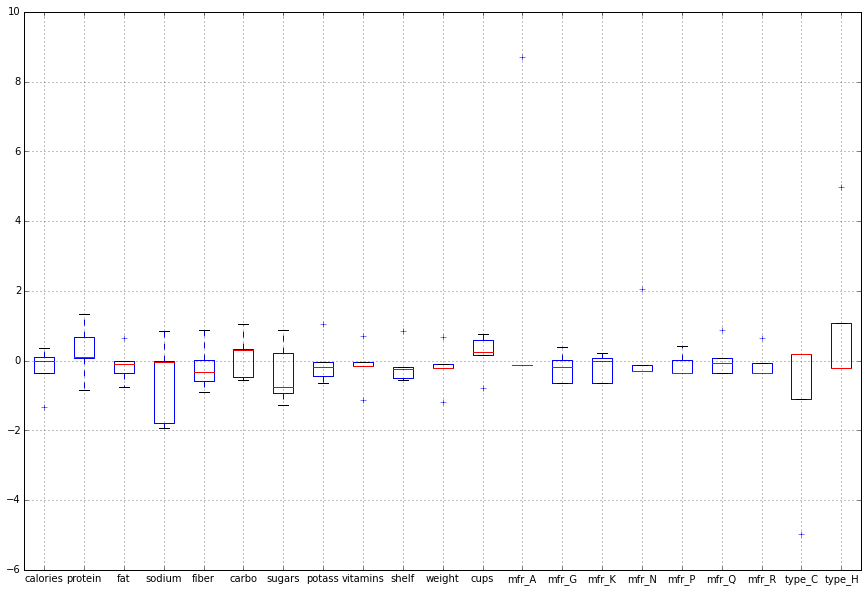

In [29]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)
# centroids.plot(figsize=(15,10), kind='bar')
# centroids.plot(figsize=(15,10), kind='box')
centroids.plot(figsize=(15,10), kind='box')
# centroids.plot(figsize=(15,10), kind='line')

###Above we can see the spread centroid coordinates in each dimension

In [27]:
df[df<0].dropna(how='all')  # no negative values

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,


In [44]:
df['label'] = np.array(clusters)

In [42]:
df.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,
100%_Bran,70,4,1,130,10,5,6,280.000000,25,3,...,0.33,0,0,0,1,0,0,0,1,0
100%_Natural_Bran,120,3,5,15,2,8,8,135.000000,0,3,...,1.00,0,0,0,0,0,1,0,1,0
All-Bran,70,4,1,260,9,7,5,320.000000,25,3,...,0.33,0,0,1,0,0,0,0,1,0
All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330.000000,25,3,...,0.50,0,0,1,0,0,0,0,1,0
Almond_Delight,110,2,2,200,1,14,8,67.170686,25,3,...,0.75,0,0,0,0,0,0,1,1,0


In [48]:
df['name'] = data.index
df = df.sort(['label', 'name'])
grouped = df.set_index(['label', 'name'])
grouped.ix[:,:-9]

calories  protein  fat  sodium  \
label name                                                                     
0     100%_Bran                                    110        2    2     200   
      100%_Natural_Bran                             90        2    1     200   
      All-Bran                                     110        6    2     290   
      All-Bran_with_Extra_Fiber                    110        2    0     280   
      Almond_Delight                               100        2    0     290   
      Apple_Cinnamon_Cheerios                      110        2    0     220   
      Apple_Jacks                                  100        2    0     190   
      Basic_4                                      110        2    1     170   
      Bran_Chex                                    140        3    1     170   
      Bran_Flakes                                  110        2    1     260   
      Cap'n'Crunch                                  90        3    0     170   
      Cheerios                                     100        3    0     320   
      Cinnamon_Toast_Crunch                        110        1    0     240   
      Clusters                                     110        2    0     290   
      Cocoa_Puffs                                  110        6    0     230   
      Corn_Chex                                    110        2    1     200   
      Corn_Flakes                                  100        3    1     200   
      Corn_Pops                                    110        2    1     250   
      Count_Chocula                                100        3    1     230   
      Cracklin'_Oat_Bran                           100        3    1     200   
1     Cream_of_Wheat_(Quick)                       110        2    2     180   
      Crispix                                      110        2    0     125   
      Crispy_Wheat_&_Raisins                       120        1    2     220   
      Double_Chex                                  120        1    3     210   
      Froot_Loops                                  110        1    1     180   
      Frosted_Flakes                               110        1    0      90   
      Frosted_Mini-Wheats                          110        1    1     180   
      Fruit_&_Fibre_Dates,_Walnuts,_and_Oats       100        2    1     140   
      Fruitful_Bran                                110        2    1     125   
      Fruity_Pebbles                               110        1    0     200   
...                                                ...      ...  ...     ...   
2     Multi-Grain_Cheerios                          50        4    0     140   
      Nut&Honey_Crunch                             130        3    2     210   
      Nutri-Grain_Almond-Raisin                     90        3    0     210   
      Nutri-grain_Wheat                            110        3    2     140   
      Oatmeal_Raisin_Crisp                         110        3    3     140   
      Post_Nat._Raisin_Bran                        120        3    2     160   
      Product_19                                   120        3    0     240   
      Puffed_Rice                                  110        3    0     170   
      Puffed_Wheat                                 100        3    1     140   
      Quaker_Oat_Squares                           120        3    3      75   
      Quaker_Oatmeal                               100        4    2     150   
      Raisin_Bran                                  150        4    3      95   
      Raisin_Nut_Bran                              150        4    3     150   
      Raisin_Squares                               160        3    2     150   
      Rice_Chex                                    140        3    2     220   
      Rice_Krispies                                130        3    2     170   
      Shredded_Wheat                               120        3    1     200   
      Shredded_Wheat_'n'Bran                  

         calories   protein       fat      sodium     fiber      carbo  \
label                                                                    
0      106.500000  2.650000  0.650000  230.000000  1.350000  18.850000   
1      109.166667  1.625000  0.916667  156.666667  0.791667  12.708333   
2      113.750000  3.291667  1.666667  160.000000  4.250000  13.041667   
3      100.000000  4.000000  1.000000    0.000000  0.000000  16.000000   
4       81.250000  2.625000  0.250000   11.875000  2.212500  16.100329   

          sugars      potass   vitamins     shelf   ...        cups  mfr_A  \
label                                               ...                      
0       3.700000   67.358534  43.750000  2.050000   ...    0.961000      0   
1      10.833333   53.958333  25.000000  1.791667   ...    0.861667      0   
2       8.000000  171.250000  27.083333  2.916667   ...    0.637917      0   
3       3.000000   95.000000  25.000000  2.000000   ...    1.000000      1   
4       1.503

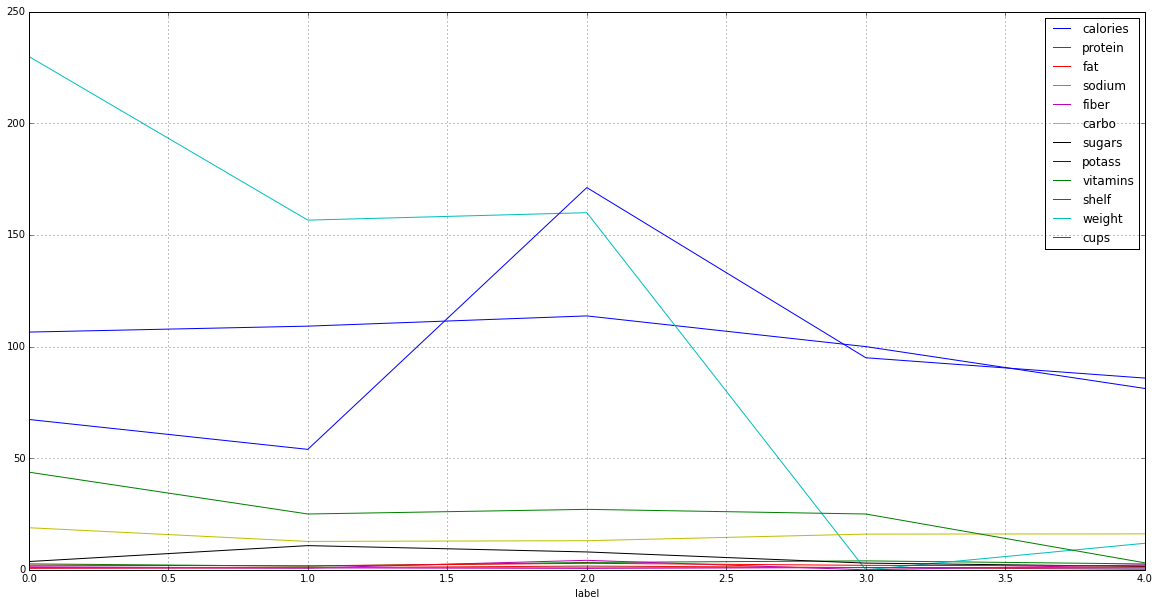

In [60]:
aggs = grouped.groupby(level='label').agg(['mean', 'std'])
means = grouped.groupby(level='label').mean()
print(means)
means.ix[:,:-9].plot(kind='line', figsize=(20,10))

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform()